# TMDL Event Study
### Goal: produce an end-to-end event study for a single TMDL, incorporating both ATTAINS and ICIS-NPDES data.
Author: Ryan Treves

In [3]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import json
from urllib.request import urlopen
import datetime as dt
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# Load data
AUs = pd.read_csv('all_AUs.csv')
assessments = pd.read_csv('all_NotSupporting_assessments.csv', dtype={'reportingCycleText': str}, parse_dates=['assessment_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))
all_actions = pd.read_csv('all_actions.csv', parse_dates=['completionDate', 'TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).drop_duplicates()
all_actions_permit_data = pd.read_csv('all_actions_permit_data.csv', dtype={'NPDESIdentifier': object}).drop('Unnamed: 0', axis=1).drop_duplicates()

In [5]:
VA_dmrs = pd.read_csv('VA_dmrs.csv', dtype={'dmr_value_standard_units': float,
                              'parameter_code': object},
                       parse_dates=['monitoring_period_end_date'],
                       date_parser=lambda t: pd.to_datetime(t, errors='coerce'))

In [6]:
VA_actions = all_actions_permit_data[all_actions_permit_data['NPDESIdentifier'].apply(lambda x: str(x)[0:2]=='VA')]
VA_actions = VA_actions.merge(all_actions, on='actionIdentifier', how='left')

In [7]:
VA_ids = list(VA_dmrs['npdes_permit_id'].unique())

In [8]:
VA_actions = VA_actions[VA_actions['NPDESIdentifier'].apply(lambda x: x in VA_ids)]

In [9]:
VA_actions.shape

(622, 15)

Let's first try actionID 64654:

In [10]:
data_subset = VA_dmrs[(VA_dmrs['npdes_permit_id'].apply(lambda x: x in ['VA0067121', 'VA0089915', 'VA0091537', 'VA0023914', 'VA0088102'])) &
        (VA_dmrs['parameter_desc'] == 'E. coli') &
        (VA_dmrs['monitoring_period_end_date'] > pd.to_datetime('2012-04-27')) &
        (VA_dmrs['monitoring_period_end_date'] < pd.to_datetime('2020-04-27'))]

Text(0.5, 1.0, 'Virginia TMDL 64654')

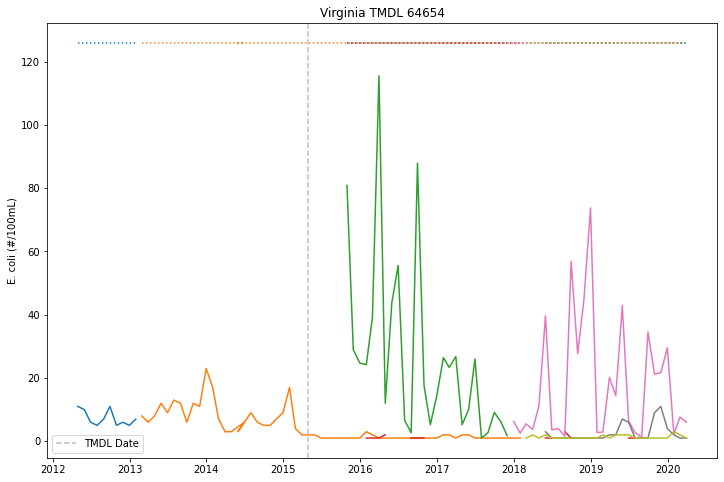

In [11]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
data_subset.sort_values(by=['series_id', 'monitoring_period_end_date'])
plt.figure(figsize=(12,8))
i=0
for series_id in data_subset['series_id'].unique():
    to_plot = data_subset[data_subset['series_id']==series_id]
    plt.plot(to_plot['monitoring_period_end_date'], to_plot['dmr_value_standard_units'], color=colors[i])
    plt.plot(to_plot['monitoring_period_end_date'], to_plot['limit_value_standard_units'], linestyle=':', color=colors[i])
    i += 1
plt.axvline(x=pd.to_datetime('2015-04-27'), color='silver', linestyle='--', label='TMDL Date')
plt.ylabel('E. coli (#/100mL)')
plt.legend()
plt.title('Virginia TMDL 64654')

Let's try a non-E. coli TMDL:

In [12]:
implicated_permittees = list(VA_actions[VA_actions['actionIdentifier']=='40209']['NPDESIdentifier'].unique())
data_subset = VA_dmrs[(VA_dmrs['npdes_permit_id'].apply(lambda x: x in implicated_permittees)) &
        (VA_dmrs['parameter_desc'].apply(lambda x: x in ['Mercury, dissolved [as Hg]', 'Mercury, sludge, total, dry weight [as Hg]', 'Mercury, total [as Hg]', 'Mercury, total recoverable']))]
data_subset.shape

(0, 75)

Interesting -- none of the implicated permittees have ever reported Mercury on their DMRs.

In [13]:
implicated_permittees = list(VA_actions[VA_actions['actionIdentifier']=='38543']['NPDESIdentifier'].unique())
data_subset = VA_dmrs[(VA_dmrs['npdes_permit_id'].apply(lambda x: x in implicated_permittees)) &
        (VA_dmrs['parameter_desc']=='Polychlorinated biphenyls [PCBs]')]
data_subset.shape

(20, 75)

Because Virginia doesn't have many recent non-E.coli TMDLs, let's try another state.

In [14]:
NM_dmrs = pd.read_csv('NM_dmrs.csv', dtype={'dmr_value_standard_units': float,
                                            'parameter_code': object},
                      parse_dates=['monitoring_period_end_date'],
                      date_parser=lambda t: pd.to_datetime(t, errors='coerce'))

In [15]:
NM_actions = all_actions_permit_data[all_actions_permit_data['NPDESIdentifier'].apply(lambda x: str(x)[0:2] == 'NM')]
NM_actions = NM_actions.merge(all_actions, on='actionIdentifier', how='left')

In [16]:
NM_ids = list(NM_dmrs['npdes_permit_id'].unique())
NM_actions = NM_actions[NM_actions['NPDESIdentifier'].apply(lambda x: x in NM_ids)]

In [17]:
implicated_permittees = list(NM_actions[NM_actions['actionIdentifier']=='66401']['NPDESIdentifier'].unique())
data_subset = NM_dmrs[(NM_dmrs['npdes_permit_id'].apply(lambda x: x in implicated_permittees)) &
        (NM_dmrs['monitoring_period_end_date'] > pd.to_datetime('2015-09-23')) &
        (NM_dmrs['monitoring_period_end_date'] < pd.to_datetime('2021-09-23'))]
data_subset.shape

(3752, 75)

Text(0.5, 1.0, 'New Mexico TMDL 66401')

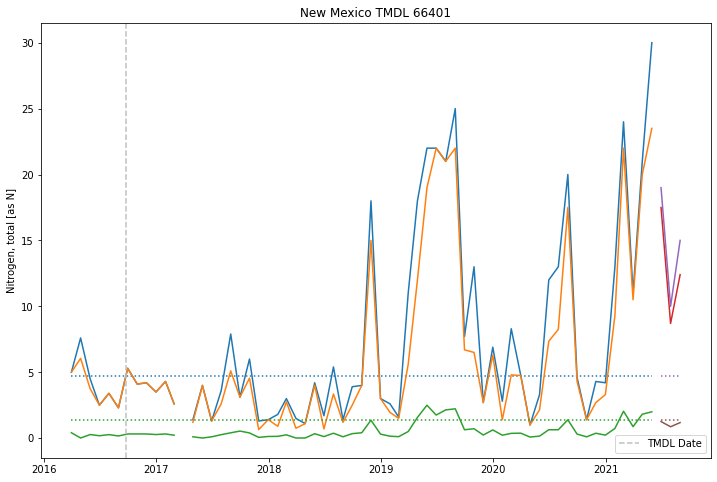

In [18]:
data_subset_N = data_subset[data_subset['parameter_desc']=='Nitrogen, total [as N]']
data_subset_N.sort_values(by=['series_id', 'monitoring_period_end_date'])
plt.figure(figsize=(12,8))
i=0
for series_id in data_subset_N['series_id'].unique():
    to_plot = data_subset_N[data_subset_N['series_id']==series_id]
    plt.plot(to_plot['monitoring_period_end_date'], to_plot['dmr_value_standard_units'], color=colors[i])
    plt.plot(to_plot['monitoring_period_end_date'], to_plot['limit_value_standard_units'], linestyle=':', color=colors[i])
    i += 1
plt.axvline(x=pd.to_datetime('2016-09-23'), color='silver', linestyle='--', label='TMDL Date')
plt.ylabel('Nitrogen, total [as N]')
plt.legend()
plt.title('New Mexico TMDL 66401')

Text(0.5, 1.0, 'New Mexico TMDL 66401')

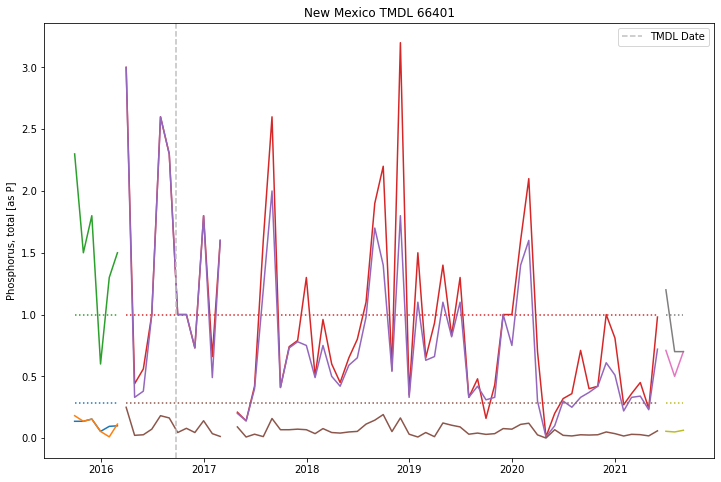

In [19]:
data_subset_P = data_subset[data_subset['parameter_desc']=='Phosphorus, total [as P]']
data_subset_P.sort_values(by=['series_id', 'monitoring_period_end_date'])
plt.figure(figsize=(12,8))
i=0
for series_id in data_subset_P['series_id'].unique():
    to_plot = data_subset_P[data_subset_P['series_id']==series_id]
    plt.plot(to_plot['monitoring_period_end_date'], to_plot['dmr_value_standard_units'], color=colors[i])
    plt.plot(to_plot['monitoring_period_end_date'], to_plot['limit_value_standard_units'], linestyle=':', color=colors[i])
    i += 1
plt.axvline(x=pd.to_datetime('2016-09-23'), color='silver', linestyle='--', label='TMDL Date')
plt.ylabel('Phosphorus, total [as P]')
plt.legend()
plt.title('New Mexico TMDL 66401')

Let's try one more example from a different state

In [20]:
SD_dmrs = pd.read_csv('SD_dmrs.csv', dtype={'dmr_value_standard_units': float,
                                            'parameter_code': object},
                      parse_dates=['monitoring_period_end_date'],
                      date_parser=lambda t: pd.to_datetime(t, errors='coerce'))

In [21]:
SD_actions = all_actions_permit_data[all_actions_permit_data['NPDESIdentifier'].apply(lambda x: str(x)[0:2] == 'SD')]
SD_actions = SD_actions.merge(all_actions, on='actionIdentifier', how='left')

In [22]:
SD_ids = list(SD_dmrs['npdes_permit_id'].unique())
SD_actions = SD_actions[SD_actions['NPDESIdentifier'].apply(lambda x: x in SD_ids)]
implicated_permittees = list(SD_actions[SD_actions['actionIdentifier']=='40439']['NPDESIdentifier'].unique())
data_subset = SD_dmrs[(SD_dmrs['npdes_permit_id'].apply(lambda x: x in implicated_permittees)) &
                      (SD_dmrs['monitoring_period_end_date'] > pd.to_datetime('2009-06-02')) &
                      (SD_dmrs['monitoring_period_end_date'] < pd.to_datetime('2016-06-02'))]

In [23]:
data_subset.shape

(4484, 75)

Text(0.5, 1.0, 'South Dakota TMDL 40439')

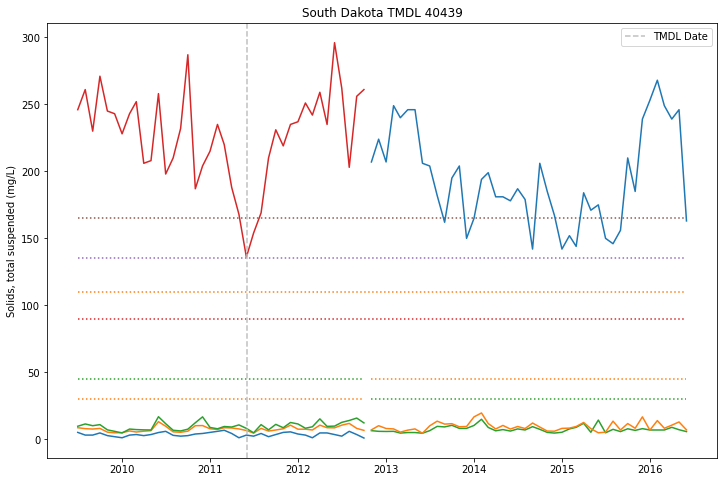

In [24]:
data_subset = data_subset[(data_subset['parameter_desc']=='Solids, total suspended')]
data_subset.sort_values(by=['series_id', 'monitoring_period_end_date'])
plt.figure(figsize=(12,8))
i=1
for series_id in data_subset['series_id'].unique():
    to_plot = data_subset[data_subset['series_id']==series_id]
    plt.plot(to_plot['monitoring_period_end_date'], to_plot['dmr_value_standard_units'], color=colors[len(data_subset['series_id'].unique()) % i])
    plt.plot(to_plot['monitoring_period_end_date'], to_plot['limit_value_standard_units'], linestyle=':', color=colors[len(data_subset['series_id'].unique()) % i])
    i += 1
plt.axvline(x=pd.to_datetime('2011-06-02'), color='silver', linestyle='--', label='TMDL Date')
plt.ylabel('Solids, total suspended (mg/L)')
plt.legend()
plt.title('South Dakota TMDL 40439')

Writing here for empty commit to create new branch